In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import re

In [169]:
regex = re.compile(r'[^a-zA-Z0-9\s\']')
def clean_text(x):
    temp = re.sub(regex, '', x)
    return re.sub(r'\s+', ' ', temp.lower().strip())

In [4]:
data_path = './ner_dataset.csv'

data = pd.read_csv(data_path, encoding='unicode_escape').fillna(method='ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [182]:
# organize data by sentences
ready_data = []
for index, group in data.groupby('Sentence #'):
    text = ' '.join(group['Word'])
    temp = [int(index.split()[-1]), text, group['POS'].to_list(), group['Tag'].to_list()]
    ready_data.append(temp)

ready_data = pd.DataFrame(ready_data, columns=['Sentence #', 'Sentence', 'POS', 'Tag']).\
sort_values('Sentence #').reset_index(drop=1)

In [183]:
ready_data

,Sentence #,Sentence,POS,Tag
0,1,Thousands of demonstrators have marched throug...,"[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
1,2,Families of soldiers killed in the conflict jo...,"[NNS, IN, NNS, VBN, IN, DT, NN, VBD, DT, NNS, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,3,They marched from the Houses of Parliament to ...,"[PRP, VBD, IN, DT, NNS, IN, NN, TO, DT, NN, IN...","[O, O, O, O, O, O, O, O, O, O, O, B-geo, I-geo..."
3,4,"Police put the number of marchers at 10,000 wh...","[NNS, VBD, DT, NN, IN, NNS, IN, CD, IN, NNS, V...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,5,The protest comes on the eve of the annual con...,"[DT, NN, VBZ, IN, DT, NN, IN, DT, JJ, NN, IN, ...","[O, O, O, O, O, O, O, O, O, O, O, B-geo, O, O,..."
...,...,...,...,...
47954,47955,Indian border security forces are accusing the...,"[JJ, NN, NN, NNS, VBP, VBG, PRP$, JJ, NNS, IN,...","[B-gpe, O, O, O, O, O, O, B-gpe, O, O, O, O, O..."
47955,47956,Indian officials said no one was injured in Sa...,"[JJ, NNS, VBD, DT, NN, VBD, VBN, IN, NNP, POS,...","[B-gpe, O, O, O, O, O, O, O, B-tim, O, O, O, O..."
47956,47957,Two more landed in fields belonging to a nearb...,"[CD, JJR, VBD, IN, NNS, VBG, TO, DT, JJ, NN, .]","[O, O, O, O, O, O, O, O, O, O, O]"
47957,47958,They say not all of the rockets exploded upon ...,"[PRP, VBP, RB, DT, IN, DT, NNS, VBD, IN, NN, .]","[O, O, O, O, O, O, O, O, O, O, O]"


In [201]:
features = ready_data['Sentence']
labels = ready_data['Tag'].to_list()

In [179]:
features

0        thousands of demonstrators have marched throug...
1        families of soldiers killed in the conflict jo...
2        they marched from the houses of parliament to ...
3        police put the number of marchers at 10000 whi...
4        the protest comes on the eve of the annual con...
                               ...                        
47954    indian border security forces are accusing the...
47955    indian officials said no one was injured in sa...
47956    two more landed in fields belonging to a nearb...
47957    they say not all of the rockets exploded upon ...
47958      indian forces said they responded to the attack
Name: Sentence, Length: 47959, dtype: object

In [147]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [148]:
features.shape

(47959,)

In [185]:
# cutoff reviews after 110 words
maxlen = 110

# consider the top 36000 words in the dataset
max_words = 36000

# tokenize each sentence in the dataset
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(features)
sequences = tokenizer.texts_to_sequences(features)

In [187]:
word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))
id2word = dict([(value, key) for (key, value) in word_index.items()])

Found 27953 unique tokens.


In [188]:
word2id = word_index

In [189]:
X_preprocessed = pad_sequences(sequences, maxlen=maxlen, padding='post')

In [190]:
X_preprocessed[22479]

array([ 9811,     2,   640,   454,  2760,   155,   944, 15986,  5319,
        1941,     3,    61,  4900,   155,  4877, 22425,  1941,    17,
       13036, 22426, 22427,     6,   699,   325,   428, 22428,  1941,
       13142, 13143, 22429, 22430,    47,   381,    25,  2859,   907,
       22431,  2166,     4,   155,  1229, 22432,  1941,     2,   754,
         629,     3,    61,  4899,   155,   975, 22433,  1941,    17,
       13036,     6,   699,   454,   428, 22434,  1941, 13142, 13143,
        1033,  1453,    21,     1,   257,  3560,    22,     1,  4417,
           3,     1,  5701,     3,  3783,  2111,  1028,  1243, 22435,
          61,  6936,  2197,  3486,     1,   135,  1185,   257,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0], dtype=int32)

In [193]:
tags = data['Tag'].unique()
tags2id = {}
for i, tag in enumerate(tags):
    tags2id[tag] = i

In [196]:
id2tag = dict(zip(tags2id.values(), tags2id.keys()))
id2tag

{0: 'O',
 1: 'B-geo',
 2: 'B-gpe',
 3: 'B-per',
 4: 'I-geo',
 5: 'B-org',
 6: 'I-org',
 7: 'B-tim',
 8: 'B-art',
 9: 'I-art',
 10: 'I-per',
 11: 'I-gpe',
 12: 'I-tim',
 13: 'B-nat',
 14: 'B-eve',
 15: 'I-eve',
 16: 'I-nat'}

In [208]:
def preprocess_tags(tags2id, Y_ready):
    
    Y_preprocessed = []
    maxlen = 110
    # for each target 
    for y in Y_ready:
        
        # place holder to store the new preprocessed tag list
        Y_place_holder = []
        
        # for each tag in rhe tag list 
        for tag in y:
            # append the id of the tag in the place holder list
            Y_place_holder.append(tags2id[tag])
        
        # find the lenght of the new preprocessed tag list 
        len_new_tag_list = len(Y_place_holder)
        # find the differance in length between the len of tag list and padded sentences
        num_O_to_add = maxlen - len_new_tag_list
        
        # add 'O's to padd the tag lists
        padded_tags = Y_place_holder + ([tags2id['O']] * num_O_to_add)
        Y_preprocessed.append(padded_tags)
        
    return Y_preprocessed

In [214]:
Y_preprocessed = np.array(preprocess_tags(tags2id, labels))

In [211]:
print("The Lenght of training examples: {}".format(len(X_preprocessed)))
print("The Lenght of training targets: {}".format(len(Y_preprocessed)))

The Lenght of training examples: 47959
The Lenght of training targets: 47959


In [217]:
# 70% of the datat will be used for training 
training_samples = 0.7
# 15% of the datat will be used for validation 
validation_samples = 0.15
# 15% of the datat will be used for testing 
testing_samples = 0.15

In [219]:
indices = np.arange(Y_preprocessed.shape[0])
np.random.shuffle(indices)

In [221]:
X_preprocessed = X_preprocessed[indices]
Y_preprocessed = Y_preprocessed[indices]

In [222]:
X_train = X_preprocessed[: int(0.7 * len(X_preprocessed))]
print("Number of training examples: {}".format(len(X_train)))


X_val = X_preprocessed[int(0.7 * len(X_preprocessed)) : int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1)]
print("Number of validation examples: {}".format(len(X_val)))


X_test = X_preprocessed[int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1) : ]
print("Number of testing examples: {}".format(len(X_test)))



Y_train = Y_preprocessed[: int(0.7 * len(X_preprocessed))]
Y_val = Y_preprocessed[int(0.7 * len(X_preprocessed)) : int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1)]
Y_test = Y_preprocessed[int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1) : ]

print("Total number of examples after shuffling and splitting: {}".format(len(X_train) + len(X_val) + len(X_test)))

Number of training examples: 33571
Number of validation examples: 7194
Number of testing examples: 7194
Total number of examples after shuffling and splitting: 47959


In [223]:
id2word[729]

'nigeria'

### Model training

In [224]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [225]:
BATCH_SIZE = 132
SHUFFLE_BUFFER_SIZE = 132

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [226]:
embedding_dim = 300
maxlen = 110
max_words = 36000
num_tags = len(tags)

model = tf.keras.models.Sequential([
    keras.layers.Embedding(max_words, embedding_dim, input_length=maxlen),
    keras.layers.Bidirectional(keras.layers.LSTM(units=100, activation='tanh', return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(units=100, activation='tanh', return_sequences=True)),
    keras.layers.TimeDistributed(keras.layers.Dense(num_tags, activation='softmax'))
])

In [227]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 110, 300)          10800000  
                                                                 
 bidirectional (Bidirectiona  (None, 110, 200)         320800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 110, 200)         240800    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 110, 17)          3417      
 ibuted)                                                         
                                                                 
Total params: 11,365,017
Trainable params: 11,365,017
Non-trainable params: 0
____________________________________________

In [228]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [229]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=15)

Epoch 1/15


2023-01-31 15:16:07.107286: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


255/255 [==============================] - 180s 699ms/step - loss: 0.1842 - accuracy: 0.9659 - val_loss: 0.1125 - val_accuracy: 0.9705
Epoch 2/15
255/255 [==============================] - 179s 702ms/step - loss: 0.0961 - accuracy: 0.9728 - val_loss: 0.0802 - val_accuracy: 0.9760
Epoch 3/15
255/255 [==============================] - 176s 691ms/step - loss: 0.0673 - accuracy: 0.9785 - val_loss: 0.0677 - val_accuracy: 0.9786
Epoch 4/15
255/255 [==============================] - 180s 708ms/step - loss: 0.0541 - accuracy: 0.9818 - val_loss: 0.0651 - val_accuracy: 0.9796
Epoch 5/15
255/255 [==============================] - 181s 709ms/step - loss: 0.0454 - accuracy: 0.9844 - val_loss: 0.0656 - val_accuracy: 0.9802
Epoch 6/15
255/255 [==============================] - 183s 717ms/step - loss: 0.0397 - accuracy: 0.9864 - val_loss: 0.0707 - val_accuracy: 0.9806
Epoch 7/15
255/255 [==============================] - 182s 713ms/step - loss: 0.0357 - accuracy: 0.9878 - val_loss: 0.0702 - val_accura

In [230]:
model.evaluate(test_dataset)

55/55 [==============================] - 12s 226ms/step - loss: 0.0995 - accuracy: 0.9803


[0.09945090860128403, 0.9802941679954529]

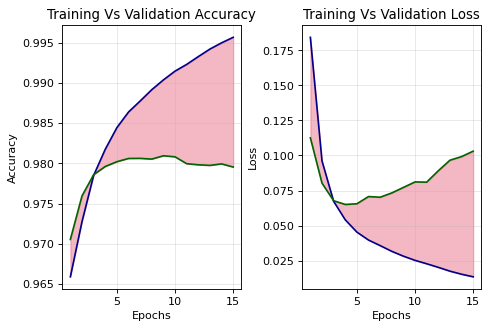

In [231]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 4), dpi=80)

ax[0].plot(epochs, acc, label = "Training Accuracy", color='darkblue')
ax[0].plot(epochs, val_acc, label = "Validation Accuracy", color='darkgreen')
ax[0].grid(alpha=0.3)
ax[0].title.set_text('Training Vs Validation Accuracy')
ax[0].fill_between(epochs, acc, val_acc, color='crimson', alpha=0.3)
plt.setp(ax[0], xlabel='Epochs')
plt.setp(ax[0], ylabel='Accuracy')


ax[1].plot(epochs, loss, label = "Training Loss", color='darkblue')
ax[1].plot(epochs, val_loss, label = "Validation Loss", color='darkgreen')
ax[1].grid(alpha=0.3)
ax[1].title.set_text('Training Vs Validation Loss')
ax[1].fill_between(epochs,loss, val_loss, color='crimson', alpha=0.3)
plt.setp(ax[1], xlabel='Epochs')
plt.setp(ax[1], ylabel='Loss')

plt.show()

In [240]:
def make_prediction(model, preprocessed_sentence, id2word, id2tag):
    
    #if preprocessed_sentence.shape() != (1, 110):
    preprocessed_sentence = preprocessed_sentence.reshape((1, 110))
     
    # return preprocessed sentence to its orginal form
    sentence = preprocessed_sentence[preprocessed_sentence > 0]
    word_list = []
    for word in list(sentence):
        word_list.append(id2word[word])
    orginal_sententce = ' '.join(word_list)
    
    len_orginal_sententce = len(word_list)
    
    # make prediction
    prediction = model.predict(preprocessed_sentence)
    prediction = np.argmax(prediction[0], axis=1)
    
    # return the prediction to its orginal form
    prediction = list(prediction)[ : len_orginal_sententce] 
    
    pred_tag_list = []
    for tag_id in prediction:
        pred_tag_list.append(id2tag[tag_id])
    
    return orginal_sententce,  pred_tag_list

In [241]:
orginal_sententce,  pred_tag_list = make_prediction(model=model,
                                                    preprocessed_sentence=X_test[520],
                                                    id2word=id2word,
                                                    id2tag=id2tag)

1/1 [==============================] - 0s 23ms/step


In [242]:
X_test[520]

array([   1,   14,   20,  230,    3,   69, 3253,   12,    1,  119,   32,
       6855,    2,    1, 1137,  292,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [243]:
print(orginal_sententce)

the u s secretary of state predicted that the talks will intensify in the coming months


In [244]:
print(pred_tag_list)

['O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
